In [1]:
import pandas as pd

In [3]:
df = pd.read_excel('./DH(임베딩컬럼만).xlsx', index_col=0)

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Conv1D, MaxPooling1D, GlobalMaxPooling1D , Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

In [5]:
dh_embedding = []
oil_embedding = []
for i in df['dh_embedding']:
    dh_embedding.append(eval(i))
    # print(eval(i))
for i in df['oil_embedding']:
    oil_embedding.append(eval(i))
df['dh_embedding_1']= dh_embedding
df['dh_embedding_2']= oil_embedding

In [6]:
df_result = pd.DataFrame()
for i in range(len(df)):
#     print(pd.DataFrame(list(X_train['dh_embedding_1'])[i]).T)

    df_result= pd.concat([df_result, pd.DataFrame(list(df['dh_embedding_1'])[i]).T], ignore_index = True)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_result, df['target'], test_size = 0.2, random_state = 1, stratify = df['target'])

In [8]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [9]:
import tensorflow as tf

In [10]:
x_train_ex = tf.expand_dims(X_train, axis=2)
x_test_ex = tf.expand_dims(X_test, axis=2)

print('원본 차원 정보 :',X_train.shape) #=> 원본 차원 정보 : (3998, 140)
print('변경된 차원 정보 :',x_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)

# (3998, 140, 1)는 각각 아래의 의미를 가진다.
# (데이터 개수, Sequence 길이, Input Vector 길이)

원본 차원 정보 : (387, 768)
변경된 차원 정보 : (387, 768, 1)


In [11]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.LSTM(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])),
    layers.Dropout(0.25),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [13]:
training_record = model.fit(x_train_ex, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_train_ex, y_train),
                    shuffle=True)

Epoch 1/30
4/4 [==============================] - 50s 10s/step - loss: 0.6909 - val_loss: 0.6847
Epoch 2/30
4/4 [==============================] - 26s 6s/step - loss: 0.6819 - val_loss: 0.6789
Epoch 3/30
4/4 [==============================] - 26s 6s/step - loss: 0.6783 - val_loss: 0.6823
Epoch 4/30
4/4 [==============================] - 27s 7s/step - loss: 0.6836 - val_loss: 0.6875
Epoch 5/30
4/4 [==============================] - 26s 7s/step - loss: 0.6944 - val_loss: 0.6871
Epoch 6/30
4/4 [==============================] - 27s 6s/step - loss: 0.6846 - val_loss: 0.6792
Epoch 7/30
4/4 [==============================] - 26s 6s/step - loss: 0.6800 - val_loss: 0.6834
Epoch 8/30
4/4 [==============================] - 27s 7s/step - loss: 0.6830 - val_loss: 0.6836
Epoch 9/30
4/4 [==============================] - 26s 6s/step - loss: 0.6828 - val_loss: 0.6823
Epoch 10/30
4/4 [==============================] - 32s 8s/step - loss: 0.6828 - val_loss: 0.6808
Epoch 11/30
4/4 [=====================

In [14]:
pred_proba = model.predict(x_test_ex)

4/4 [==============================] - 3s 358ms/step


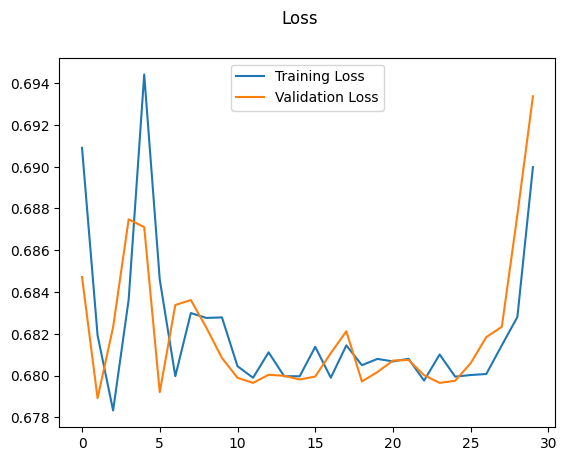

In [15]:
fig, ax = plt.subplots()
plt.plot(training_record.history["loss"], label="Training Loss")
plt.plot(training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

In [16]:
# 2차원인 pred_proba를 1차원으로 변경해준다 (1000,1)=>(1000)
pred_proba_1d = pred_proba.reshape(-1)

# 임계치 이상이면 True 미만이면 False를 부여한다.
threshold = 0.449
pred = (pred_proba_1d >= threshold)

In [17]:
# Compute the metrics
accuracy_test_rnn= accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy_test_rnn}')
#=> Accuracy: 0.988

precision_test_rnn=precision_score(y_test, pred)
print(f'Precision = {round(precision_test_rnn,3)}')
#=> Precision = 0.99

recall_test_rnn=recall_score(y_test, pred)
print(f'Recall = {round(recall_test_rnn,3)}')
#=> Recall = 0.99

f1_test_rnn=f1_score(y_test, pred)
print(f'f1 score = {round(f1_test_rnn,3)}')

Accuracy: 0.5773195876288659
Precision = 0.0
Recall = 0.0
f1 score = 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 모델 저장
# torch.save(model, f'./model.pt')

In [19]:
# 모델을 저장하는 코드
model.save('pretrained_model.h5')

In [20]:
df_result = pd.DataFrame()
for i in range(len(df)):
#     print(pd.DataFrame(list(X_train['dh_embedding_1'])[i]).T)

    df_result= pd.concat([df_result, pd.DataFrame(list(df['dh_embedding_2'])[i]).T], ignore_index = True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_result, df['target'], test_size = 0.2, random_state = 1, stratify = df['target'])

In [22]:
x_train_ex = tf.expand_dims(X_train, axis=2)
x_test_ex = tf.expand_dims(X_test, axis=2)

print('원본 차원 정보 :',X_train.shape) #=> 원본 차원 정보 : (3998, 140)
print('변경된 차원 정보 :',x_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)

# (3998, 140, 1)는 각각 아래의 의미를 가진다.
# (데이터 개수, Sequence 길이, Input Vector 길이)

원본 차원 정보 : (387, 768)
변경된 차원 정보 : (387, 768, 1)


In [24]:
# 1. 기존에 학습한 모델 불러오기
from tensorflow.keras.models import load_model

pretrained_model = load_model('./pretrained_model.h5')


# 2. 모델의 일부 층 동결
for layer in pretrained_model.layers:
    layer.trainable = False

# 3. 새로운 출력층 추가
output_layer = layers.Dense(1, activation='sigmoid')(pretrained_model.layers[-2].output)

# 4. 전체 모델 구성
transfer_model = tf.keras.Model(inputs=pretrained_model.input, outputs=output_layer)

# 5. 모델 컴파일
transfer_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# 6. 전이 학습 진행
transfer_model.fit(x_train_ex, y_train,
                   epochs=30,
                   batch_size=128,
                   validation_data=(x_train_ex, y_train),
                   shuffle=True)

Epoch 1/30
4/4 [==============================] - 20s 4s/step - loss: 0.6981 - val_loss: 0.6967
Epoch 2/30
4/4 [==============================] - 13s 4s/step - loss: 0.6965 - val_loss: 0.6952
Epoch 3/30
4/4 [==============================] - 13s 4s/step - loss: 0.6960 - val_loss: 0.6939
Epoch 4/30
4/4 [==============================] - 14s 4s/step - loss: 0.6953 - val_loss: 0.6926
Epoch 5/30
4/4 [==============================] - 13s 4s/step - loss: 0.6937 - val_loss: 0.6914
Epoch 6/30
4/4 [==============================] - 13s 4s/step - loss: 0.6904 - val_loss: 0.6899
Epoch 7/30
4/4 [==============================] - 13s 4s/step - loss: 0.6908 - val_loss: 0.6885
Epoch 8/30
4/4 [==============================] - 16s 5s/step - loss: 0.6899 - val_loss: 0.6872
Epoch 9/30
4/4 [==============================] - 24s 7s/step - loss: 0.6869 - val_loss: 0.6860
Epoch 10/30
4/4 [==============================] - 16s 5s/step - loss: 0.6866 - val_loss: 0.6851
Epoch 11/30
4/4 [======================

In [25]:
pred_proba = model.predict(x_test_ex)

4/4 [==============================] - 2s 372ms/step


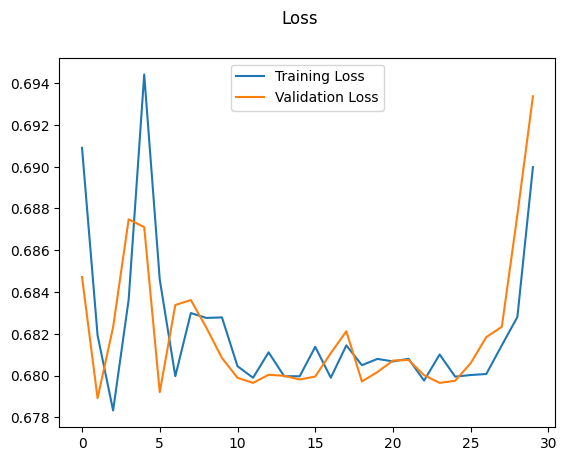

In [26]:
fig, ax = plt.subplots()
plt.plot(training_record.history["loss"], label="Training Loss")
plt.plot(training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

In [45]:
# 2차원인 pred_proba를 1차원으로 변경해준다 (1000,1)=>(1000)
pred_proba_1d = pred_proba.reshape(-1)

# 임계치 이상이면 True 미만이면 False를 부여한다.
threshold = 0.4
pred = (pred_proba_1d >= threshold)

In [46]:
# Compute the metrics
accuracy_test_rnn= accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy_test_rnn}')
#=> Accuracy: 0.988

precision_test_rnn=precision_score(y_test, pred)
print(f'Precision = {round(precision_test_rnn,3)}')
#=> Precision = 0.99

recall_test_rnn=recall_score(y_test, pred)
print(f'Recall = {round(recall_test_rnn,3)}')
#=> Recall = 0.99

f1_test_rnn=f1_score(y_test, pred)
print(f'f1 score = {round(f1_test_rnn,3)}')

Accuracy: 0.5773195876288659
Precision = 0.0
Recall = 0.0
f1 score = 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
